## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from orbit.models import KTR
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

In [2]:
import orbit

print(orbit.__version__)

1.1.0


In [3]:
# https://arziv.org/pdf/2106.03322.pdf
SEED = 42
np.random.seed(SEED)

min_date = pd.to_datetime("2018-01-01")
maz_date = pd.to_datetime("2022-01-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=maz_date, freq="W-MON")}
)

n = data_df.shape[0]

z1 = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z1"] = np.where( z1 > 0.80, z1, 0)

z2 = np.random.normal(loc=0.0, scale=0.2, size=n)
data_df["z2"] = np.where(abs(z2) > 0.15, z2, 0)
data_df["z3"] = 0.8 * data_df["z2"] + np.random.normal(loc=0.0, scale=0.05, size=n)
data_df["z4"] = np.random.normal(loc=0.5, scale=0.2, size=n)

## Generate Sample Data

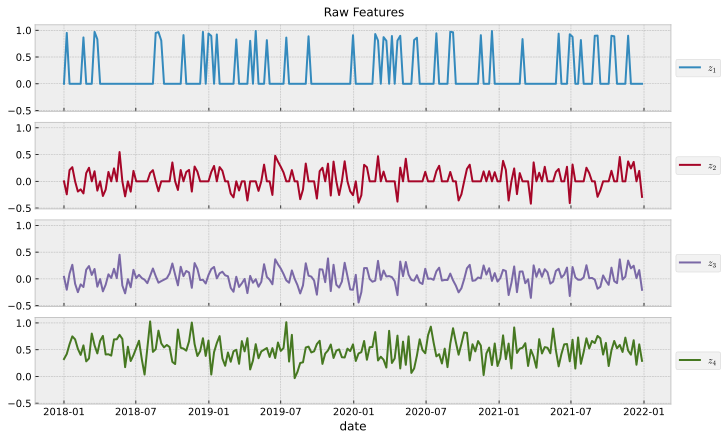

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=True, layout="constrained")

for i, ax in enumerate(axes.flatten()):
    sns.lineplot(x="date", y=f"z{i + 1}", color=f"C{i}", label=f"$z_{i + 1}$", data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(ylabel=None)

fig.suptitle("Raw Features");

In [5]:
np.random.seed(SEED)

data_df["beta1"] = 1 / (np.arange(start=0.0, stop=1.0, step=1/n) + 1)**2

beta2 = np.ones(shape=n)

for i in range(1, n):
    mu = beta2[i - 1] + np.random.normal(loc=0.0, scale=0.01)
    beta2[i] = np.random.normal(loc=mu, scale=0.05)

data_df["beta2"] = 1.5 * beta2
data_df["beta3"] = beta2
data_df["beta4"] = 0.0

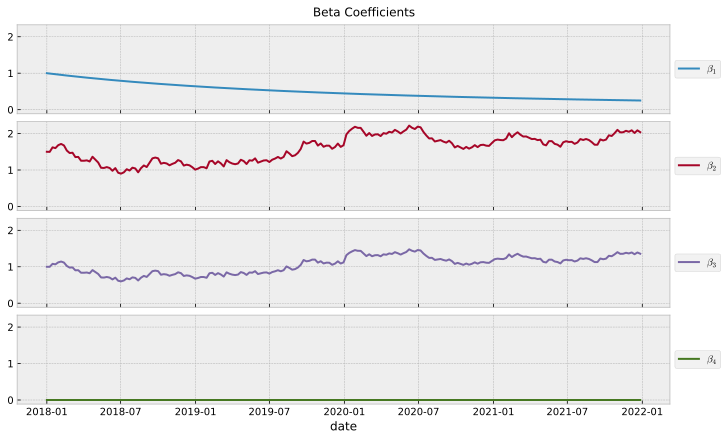

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=True, layout="constrained")

for i, ax in enumerate(axes.flatten()):
    sns.lineplot(x="date", y=f"beta{i + 1}", color=f"C{i}", label=f"$\\beta_{i + 1}$", data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(ylabel=None)

fig.suptitle("Beta Coefficients");

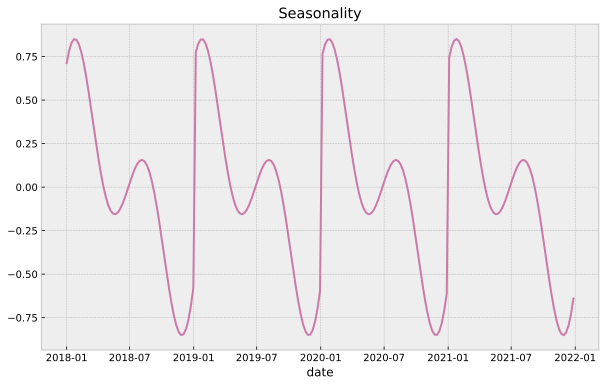

In [7]:
data_df["cs"] = np.sin(2 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["cc"] = np.cos(3 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["s"] = 0.7 * (data_df["cs"] + data_df["cc"])
data_df["intercept"] = 2.0

fig, ax = plt.subplots()
sns.lineplot(x="date", y="s", color="C5", data=data_df, ax=ax)
ax.set(title="Seasonality", ylabel="");

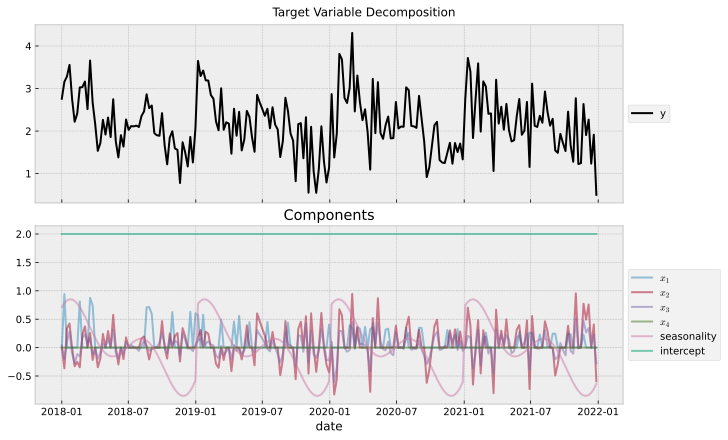

In [8]:
for i in range(1, 5):
    data_df[f"x{i}"] = data_df[f"beta{i}"] * data_df[f"z{i}"]

data_df["y"] = (
    data_df["x1"] + 
    data_df["x2"] + 
    data_df["x3"] + 
    data_df["x4"] + 
    data_df["s"] + 
    data_df["intercept"] +
    np.random.normal(loc=0.0, scale=0.005, size=n)
)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, layout="constrained")

sns.lineplot(x="date", y="y", color="black", label="y", data=data_df, ax=ax[0])
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set(ylabel=None)

for i in range(1, 5):
    sns.lineplot(x="date", y=f"x{i}", color=f"C{i - 1}", alpha=0.5, label=f"$x_{i}$", data=data_df, ax=ax[1])

sns.lineplot(x="date", y="s", color="C5", alpha=0.5, label="seasonality", data=data_df, ax=ax[1])
sns.lineplot(x="date", y="intercept", color="C7", alpha=0.5, label="intercept", data=data_df, ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set(title="Components", ylabel=None)

fig.suptitle("Target Variable Decomposition");

In [9]:
model_data_df = data_df[["date", "z1", "z2", "z3", "z4", "y"]].copy()

train_test_date = pd.to_datetime("2021-01-01")

train_df = model_data_df.query("date <= @train_test_date")
test_df = model_data_df.query("date > @train_test_date")

## Fit Model

In [10]:
date_col = "date"
response_col = "y"
regressor_col = ["z1", "z2", "z3" ,"z4"]

ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    prediction_percentiles=[2.5, 97.5],
    seasonality=[52.25],
    seed=42,
    estimator='pyro-svi',
)

In [11]:
ktr.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -4555.53
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19        5.8798      0.077571       58.5936      0.5789      0.5789       22   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       13.2772    0.00266286       38.5762      0.6788      0.6788       46   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       13.7343   0.000130976       35.0866       0.338           1       79   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       13.7414   7.81558e-06        30.687           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       13.7424   0.000143047        40.037          10           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha  

## Generate Predictions and Evaluate Model

In [12]:
in_sample_pred_df = ktr.predict(df=train_df, decompose=True)
out_sample_pred_df = ktr.predict(df=test_df, decompose=True)

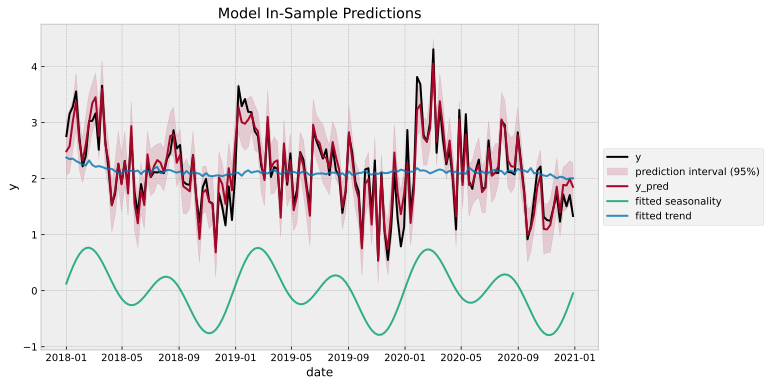

In [13]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", label="y", data=train_df, ax=ax)
ax.fill_between(
    x=in_sample_pred_df["date"],
    y1=in_sample_pred_df["prediction_2.5"],
    y2=in_sample_pred_df["prediction_97.5"],
    color="C1",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(x="date", y="prediction", color="C1", label="y_pred", data=in_sample_pred_df, ax=ax)
sns.lineplot(x="date", y="seasonality_52.25", alpha=0.8, color="C7", label="fitted seasonality", data=in_sample_pred_df, ax=ax)
sns.lineplot(x="date", y="trend", color="C9", alpha=0.8, label="fitted trend", data=in_sample_pred_df, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title="Model In-Sample Predictions");

<AxesSubplot:xlabel='date', ylabel='s'>

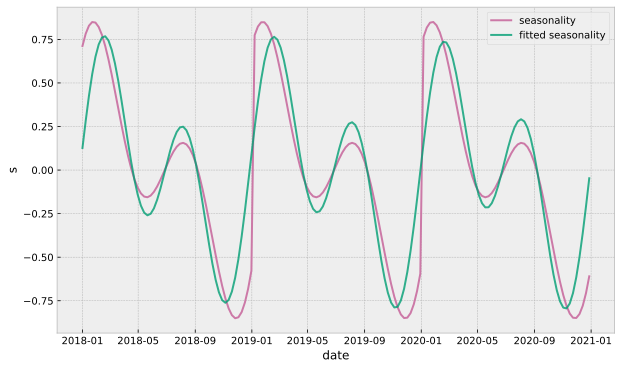

In [24]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="s", color="C5", label="seasonality", data=data_df.query("date <= @train_test_date"), ax=ax)
sns.lineplot(x="date", y="seasonality_52.25", alpha=0.8, color="C7", label="fitted seasonality", data=in_sample_pred_df, ax=ax)

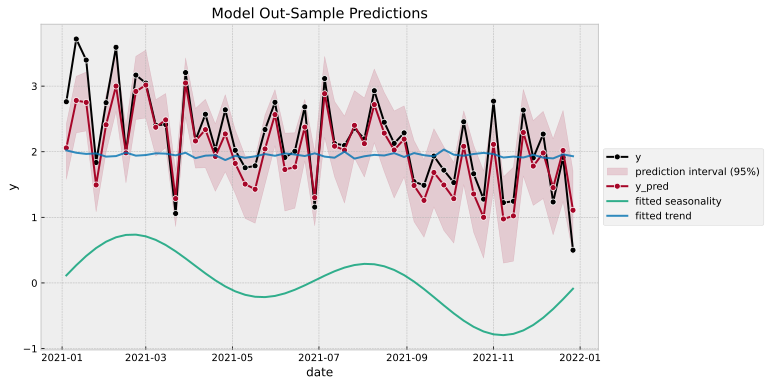

In [14]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", marker="o", color="black", label="y", data=test_df, ax=ax)
ax.fill_between(
    x=out_sample_pred_df["date"],
    y1=out_sample_pred_df["prediction_2.5"],
    y2=out_sample_pred_df["prediction_97.5"],
    color="C1",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(x="date", y="prediction", marker="o", color="C1", label="y_pred", data=out_sample_pred_df, ax=ax)
sns.lineplot(x="date", y="seasonality_52.25", alpha=0.8, color="C7", label="fitted seasonality", data=out_sample_pred_df, ax=ax)
sns.lineplot(x="date", y="trend", color="C9", alpha=0.8, label="fitted trend", data=out_sample_pred_df, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title="Model Out-Sample Predictions");

In [15]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

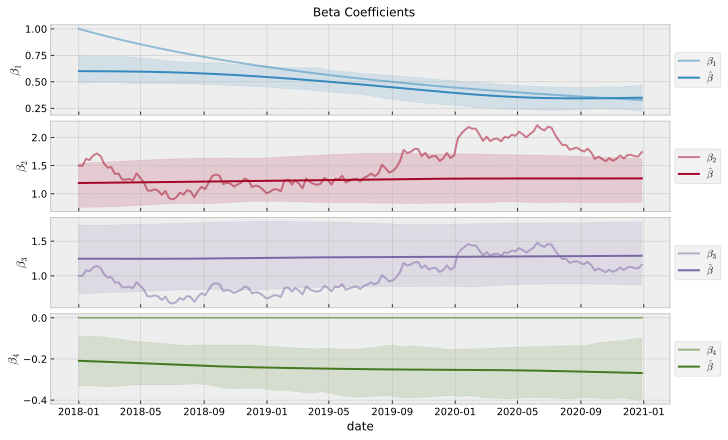

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, layout="constrained")

for i, ax in enumerate(axes.flatten()):
    sns.lineplot(x="date", y=f"beta{i + 1}", color=f"C{i}", alpha=0.5, label=f"$\\beta_{i + 1}$", data=data_df.query("date <= @train_test_date"), ax=ax)
    sns.lineplot(x="date", y=f"z{i + 1}", color=f"C{i}", label="$\hat{\\beta}$", data=coef_mid, ax=ax)
    ax.fill_between(x=coef_mid["date"], y1=coef_lower[f"z{i + 1}"], y2=coef_upper[f"z{i + 1}"], color=f"C{i}", alpha=0.15)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(ylabel=f"$\\beta_{i + 1}$");

fig.suptitle("Beta Coefficients");

In [17]:
dir(ktr)[-35:]

['_prediction_percentiles',
 '_set_prediction_meta',
 '_set_training_meta',
 '_training_data_input',
 '_training_meta',
 '_training_metrics',
 '_validate_supported_estimator_type',
 '_validate_training_df',
 'date_col',
 'estimator',
 'estimator_type',
 'extra_methods',
 'fit',
 'get_level_knots',
 'get_levels',
 'get_point_posteriors',
 'get_posterior_samples',
 'get_prediction_meta',
 'get_regression_coef_knots',
 'get_regression_coefs',
 'get_regressors',
 'get_training_data_input',
 'get_training_meta',
 'get_training_metrics',
 'is_fitted',
 'load_extra_methods',
 'n_bootstrap_draws',
 'plot_lev_knots',
 'plot_regression_coefs',
 'predict',
 'prediction_array',
 'prediction_percentiles',
 'response_col',
 'set_forecaster_training_meta',
 'set_training_data_input']

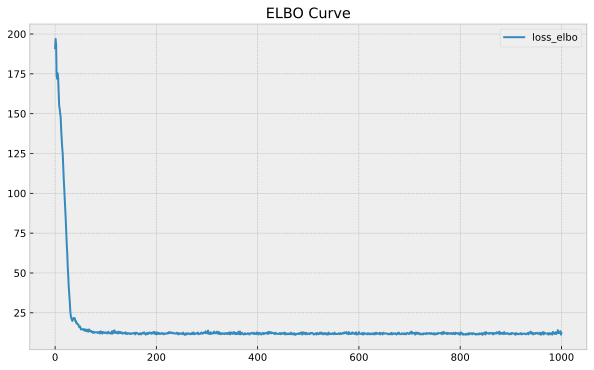

In [18]:
fig, ax = plt.subplots()
pd.DataFrame(data=ktr.get_training_metrics()).plot(ax=ax)
ax.set(title="ELBO Curve");

In [19]:
ktr.extra_methods

['get_level_knots',
 'get_levels',
 'get_regression_coef_knots',
 'get_regression_coefs',
 'plot_lev_knots',
 'plot_regression_coefs']

In [20]:
ktr.get_posterior_samples().keys()

dict_keys(['lev_knot', 'lev', 'yhat', 'obs_scale', 'coef_knot', 'coef_init_knot', 'coef'])